# **Проект: Классификация клиентов банка для выявления склонных к открытию депозитов и повышения эффективности маркетинговой кампании**

**Исходные данные:**<br>
данные о последней маркетинговой кампании, которую проводил банк (задачей было привлечь клиентов для открытия депозита)

**Бизнес-задача:** определить характеристики, по которым можно выявить клиентов, более склонных к открытию депозита в банке, и за счёт этого повысить результативность маркетинговой кампании.

**Техническая задача:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать, воспользуется он предложением об открытии депозита или нет.

In [ ]:
# Подключаем библиотеки
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

## **Часть 1. Знакомство с данными, обработка пропусков и выбросов**

### Знакомство с данными

In [ ]:
# Монтируем Google Диск
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Загружаем данныеmy
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/My_learning/bank_fin.csv', sep = ';')

In [ ]:
# Выводим несколько первых строк датафрейма
display(df.head(2))
# Выводим несколько последних строк датафрейма
display(df.tail(2))

age     job  marital  education default       balance housing loan  \
0   59  admin.  married  secondary      no   2 343,00 $      yes   no   
1   56  admin.  married  secondary      no      45,00 $       no   no   

   contact  day month  duration  campaign  pdays  previous poutcome deposit  
0  unknown    5   may      1042         1     -1         0  unknown     yes  
1  unknown    5   may      1467         1     -1         0  unknown     yes

age         job  marital  education default balance housing loan  \
11160   43  technician  married  secondary      no   0  $       no  yes   
11161   34  technician  married  secondary      no   0  $       no   no   

        contact  day month  duration  campaign  pdays  previous poutcome  \
11160  cellular    8   may         9         2    172         5  failure   
11161  cellular    9   jul       628         1     -1         0  unknown   

      deposit  
11160      no  
11161      no

In [ ]:
# Размерность датафрейма
df.shape

(11162, 17)

**Признаки**

**данные о клиентах банка:**

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

**данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

**прочие признаки:**

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная **deposit**, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.


#### 1. Исследуем данные на предмет пропусков.

In [ ]:
# Выводим основную информацию о числе непустых значений в столбцах и их типах в датафрейме
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [ ]:
# Выполним проверку на наличие пропущенных значений NaN в датафрейме
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

**Вывод:** <br>
В датафрейме 11 162 записи, 17 признаков. Пропущенные значения присутствуют в признаке: balance - 25 пропущенных значения.

#### 2. Проверим есть ли в признаке job пропущенные значения

In [ ]:
df['job'].value_counts()

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64

**Вывод:** <br>
Значение признака 'job': unknown является скрытым пропуском (70 пропущенных значений).

#### 3. Преобразуем признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)

In [ ]:
# Убираем знаки пробела и доллара, запятую меняем на точку
df['balance'] = df['balance'].apply(lambda x: str(x).replace(" ", "").replace("$", "").replace(",", "."))

In [ ]:
# Преобразуем тип данных в столбце balance  в тип данных float
df['balance'] = df['balance'].astype('float')

In [ ]:
# Среднее значение по признаку 'balance'
round((df['balance'].mean()), 3)

1529.129

#### 4. Обработаем пропуски в признаке balance , заменив их на медианные значения по данному признаку

In [ ]:
# Обработаем пропуски в признаке balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

In [ ]:
# Проверим на отсутствие пропусков в признаке balance
df['balance'].isna().sum()

0

In [ ]:
# Вычислим среднее значение по преобразованному признаку balance
round((df['balance'].mean()), 3)

1526.936

#### 5. Обработаем пропуски в категориальных признаках: job и education, заменив их на модальные значения

In [ ]:
#  Заменим для каждого пропущенного значения в признаке job, если значение равно 'unknown',  на моду (наиболее часто встречающееся значение) этого признака
df['job'] = df['job'].apply(lambda x: df['job'].mode()[0] if x=='unknown' else x)

In [ ]:
# Выполним проверку, сколько скрытых пропущенных значений в признаке education
df['education'].value_counts()

education
secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: count, dtype: int64

In [ ]:
#  Заменим для каждого пропущенного значения в признаке education, если значение равно 'unknown',  на моду (наиболее часто встречающееся значение) этого признака
df['education'] = df['education'].apply(lambda x: df['education'].mode()[0] if x=='unknown' else x)

После замены пропусков рассчитаем средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования (т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). Ответ округлите до трёх знаков после точки-разделителя.

In [ ]:
# Найдем самую популярную работу и образование
print(df['job'].mode())
print(df['education'].mode())

0    management
Name: job, dtype: object
0    secondary
Name: education, dtype: object


In [ ]:
# Отфильтруем данные для клиентов у кого одновременно самая популярная работа и самое популярное образование
df_new = df[(df['job'] == 'management') & (df['education'] == 'secondary')]

# Вычислим среднее значения признака balance
round((df_new['balance'].mean()), 3)

1598.883

#### 6.
* Изучим признак, отображающий баланс клиентов, на предмет выбросов.
* Удалим все выбросы для признака balance.
* Так как в математической статистике есть несколько подходов, позволяющих определить наличие выбросов. Мы будем считать, что выбросы находятся за пределами отрезка, нижняя граница которого определяется как нижний квартиль, из которого вычли полтора межквартильных размаха () , а верхняя граница — как верхний квартиль, к которому прибавили полтора межквартильных размаха. (). Найдем эти границы, и отфильтруем значения так, чтобы выбросов в данных не осталось.

In [ ]:
# Удалим все выбросы для признака balance методом межквартильного размаха (Тьюки)
quantile_1, quantile_3 = df['balance'].quantile(0.25), df['balance'].quantile(0.75) # вычислим 25-ый и 75-ый квантили (первый и третий квартили)
iqr = quantile_3 - quantile_1 # вычислим межквартильное расстояние
# Вычислим верхнюю и нижнюю границы Тьюки
lower_bound = quantile_1 - iqr * 1.5
upper_bound = quantile_3 + iqr * 1.5
print('Нижняя граница {:.0f}'.format(lower_bound))
print('Верхняя граница {:.0f}'.format(upper_bound))
outliers = df[(df['balance'] <= lower_bound) | (df['balance'] >= upper_bound)]
df = df[(df['balance'] >= lower_bound) & (df['balance'] <= upper_bound)].reset_index().drop('index', axis=1)
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {df .shape[0]}')

Нижняя граница -2241
Верхняя граница 4063
Число выбросов по методу Тьюки: 1058
Результирующее число записей: 10105


## **Часть 2:  Разведывательный анализ**

### Задание 1

Изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат

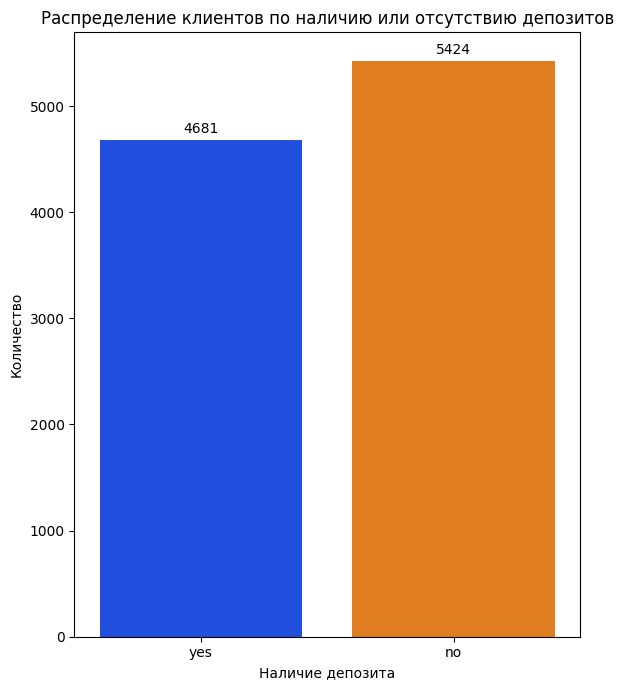

In [ ]:
# Настройка холста
fig, ax = plt.subplots(1, 1, figsize=(6, 7))

# Построим гистограмму для признака deposit
ax = sns.countplot(data=df, x='deposit', palette='bright', ax=ax)
ax.set_title('Распределение клиентов по наличию или отсутствию депозитов')
ax.set(xlabel='Наличие депозита', ylabel='Количество')

# Добавим аннотации для отображения количества
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10, padding=3)

plt.tight_layout()
plt.show()

In [ ]:
# или выполним код
df['deposit'].value_counts()

deposit
no     5424
yes    4681
Name: count, dtype: int64

### Задания 2 и 3

Рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат

In [ ]:
# Сводная статистика по датафрейму (для числовых признаков)
df.describe()

age       balance           day      duration      campaign  \
count  10105.000000  10105.000000  10105.000000  10105.000000  10105.000000   
mean      40.895497    807.653538     15.590302    368.742603      2.517170   
std       11.734931    994.151966      8.441510    346.651524      2.707159   
min       18.000000  -2049.000000      1.000000      2.000000      1.000000   
25%       32.000000     95.000000      8.000000    137.000000      1.000000   
50%       38.000000    445.000000     15.000000    252.000000      2.000000   
75%       48.000000   1227.000000     22.000000    490.000000      3.000000   
max       95.000000   4063.000000     31.000000   3881.000000     43.000000   

              pdays      previous  
count  10105.000000  10105.000000  
mean      51.319644      0.816230  
std      109.644179      2.243795  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%        2.000000      1.000000  
max      854.000000     58.000000

In [ ]:
# проведём замену значений целевого признака deposit на булевые: 1 - 'yes', 0 - 'no'
df['deposit'] = df['deposit'].apply(lambda x:int(1) if x == 'yes' else int(0))

Визуализируем зависимости целевого признака(deposit - клиенты открывшие депозит) от количественных переменных. Сделаем промежуточные выводы.

* **age(возраст)**

In [ ]:
# Группируем данные по возрасту и суммируем количество депозитов
grouped_data = df.groupby('age')['deposit'].sum().reset_index()

# Создаем линейный график
fig = px.line(
    grouped_data,
    x='age',
    y='deposit',
    title='Зависимость целевого признака (deposit) от возраста'
)

fig.show()

**Вывод:** <br>
Признак возраст имеет распределение в диапазоне от 18 до 95 лет. На графике видно, что начиная от 18 лет резко возрастает в абсолютном значении количество открываемых депозитов клиентами банка достигая пика при age=31-33 года, далее достигнув возраста 36 лет - только плавно падая.

* **day(день, в который был последний контакт)**

In [ ]:
# Группируем данные по дням и суммируем количество депозитов
grouped_data = df.groupby('day')['deposit'].sum().reset_index()

# Создаем линейный график
fig = px.line(
    grouped_data,
    x='day',
    y='deposit',
    title='Зависимость целевого признака (deposit) от дня месяца, в который был последний контакт'
)

fig.show()

**Вывод:**<br>
Как видно из графика, наблюдаются локальные пики в конце месяца на (30-й день), в середине месяца (с 12-го по 18-й дни) и в начале месяца (4-5-е дни). Также отмечаются локальные минимумы: первый и последний дни месяца, 10-й день, а также 19-й и 24-й дни месяца. Это может быть связано с получением клиентами доходов в пиковые дни (ЗП, пенсионных и соцвыплат).

* **duration(продолжительность контакта в секундах)**

In [ ]:
# Группируем данные по продолжительности контакта (duration) и суммируем количество депозитов
grouped_data = df.groupby('duration')['deposit'].sum().reset_index()

# Создаем линейный график
fig = px.line(
    grouped_data,
    x='duration',
    y='deposit',
    title='Зависимость целевого признака (deposit) от продолжительности контакта в секундах'
)

fig.show()

**Вывод:** <br>
Как видно из графика, увеличение продолжительности контакта приводит к росту целевой переменной deposit примерно до 300 секунд, после чего происходит снижение.

* **campaign(количество контактов с этим клиентом в течение текущей кампании)**

In [ ]:
# Группируем данные по количеству контактов (campaign) и суммируем количество депозитов
grouped_data = df.groupby('campaign')['deposit'].sum().reset_index()

# Создаем линейный график
fig = px.line(
    grouped_data,
    x='campaign',
    y='deposit',
    title='Зависимость целевого признака (deposit) от количества контактов с клиентом в текущей кампании'
)

# Отображаем график
fig.show()

**Вывод:** <br>
График зависимости показывает, что оптимальным количеством контактов банка с клиентом может быть 3-4, поскольку именно в этом диапазоне вероятность открытия депозита наиболее высокая.

* **previous(количество контактов до текущей кампании)**

In [ ]:
# Группируем данные по количеству предыдущих контактов (previous) и суммируем количество депозитов
grouped_data = df.groupby('previous')['deposit'].sum().reset_index()

# Создаем линейный график
fig = px.line(
    grouped_data,
    x='previous',
    y='deposit',
    title='Зависимость количества открытых депозитов от числа контактов до текущей кампании'
)

# Отображаем график
fig.show()

**Вывод:** <br>
Как видно из графика, чем меньше контактов было с клиентом до текущей кампании, тем выше шанс открытия депозита клиентом. При контактах банка с клиентом более 5 раз шансы на открытия депозита становятся нулевыми.

### Задания 4 и 5

Рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат

In [ ]:
# Сводная статистика по датафрейму (за исключением числовых признаков)
df.describe(include='object')

job  marital  education default housing   loan   contact  \
count        10105    10105      10105   10105   10105  10105     10105   
unique          11        3          3       2       2      2         3   
top     management  married  secondary      no      no     no  cellular   
freq          2315     5715       5517    9939    5243   8712      7283   

        month poutcome  
count   10105    10105  
unique     12        4  
top       may  unknown  
freq     2617     7570

* **job(сфера занятости)**

In [ ]:
# Построим сводную таблицу для подсчета количества дней по сферам занятости (job) и статусу депозита (deposit)
pivot_data = df.pivot_table(
    values='day',
    index='job',
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index()

# Создаем группированный столбчатый график
fig = px.bar(
    pivot_data,
    x='job',
    y=[0, 1],  # где количество клиентов без депозита (0) и с депозитом (1)
    orientation='v',
    text_auto=True,
    barmode='group',
    title='Распределение депозитов по сферам занятости'
)

fig.show()

**Вывод:** <br>
Как видно из полученного графика, наблюдается склонность к открытию депозитов у клиентов, находящихся на пенсии (retired), среди студентов (student) и безработных (unemployed). Чаще всего отказываются открывать депозиты клиенты рабочих профессий (blue-collar), предприниматели (entrepreneur) и сотрудники, занятые в сфере обслуживания (housemaid).

* **marital(семейное положение)**

In [ ]:
# Построим сводную таблицу для подсчета количества дней по семейному положению (marital) и статусу депозита (deposit)
pivot_data = df.pivot_table(
    values='day',
    index='marital',
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index()

# Создаем группированный столбчатый график
fig = px.bar(
    pivot_data,
    x='marital',
    y=[0, 1],     # где количество клиентов без депозита (0) и с депозитом (1)
    orientation='v',
    text_auto=True,
    barmode='group',
    title='Распределение депозитов по семейному положению'
)

fig.show()

**Вывод:** <br>
Как видно из графика, для людей с семейным положением "холост" (single) наблюдается склонность к открытию депозита, а не отказу от его открытия.

* **education(уровень образования)**

In [ ]:
# Построим сводную таблицу для подсчета количества дней по уровню образования (education) и статусу депозита (deposit)
pivot_data = df.pivot_table(
    values='day',
    index='education',
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index()

# Создаем группированный столбчатый график
fig = px.bar(
    pivot_data,
    x='education',
    y=[0, 1],       # где количество клиентов без депозита (0) и с депозитом (1)
    orientation='v',
    text_auto=True,
    barmode='group',
    title='Распределение депозитов по уровням образования'
)

fig.show()

**Вывод:** <br>
Как видно из графика, прослеживается положительная тенденция открытия депозита клиентов с уровнем образования "высшее" tertiary.

* **housing(имеется ли кредит на жильё)**

In [ ]:
# Построим сводную таблицу для подсчета количества дней по наличию кредита на жильё (housing) и статусу депозита (deposit)
pivot_data = df.pivot_table(
    values='day',
    index='housing',
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index()

# Создаем группированный столбчатый график
fig = px.bar(
    pivot_data,
    x='housing',
    y=[0, 1],     # где количество клиентов без депозита (0) и с депозитом (1)
    orientation='v',
    text_auto=True,
    barmode='group',
    title='Распределение депозитов по наличию кредита на жильё'
)

fig.show()

**Вывод:** <br>
Согласно полученному графику, наблюдается явная тенденция: клиенты, не имеющие кредита на жильё, в большинстве случаев соглашаются на открытие депозитов, в отличие от тех, кто имеет кредит, что может свидетельствовать о наличии у них свободных средств.

* **month(месяц, в котором был последний контакт)**

In [ ]:
# Построим сводную таблицу для подсчета количества дней по месяцу контакта (month) и статусу депозита (deposit)
pivot_data = df.pivot_table(
    values='day',
    index='month',
    columns='deposit',
    aggfunc='count',
    fill_value=0
).sort_index(ascending=False).reset_index()

# Создаем группированный столбчатый график
fig = px.bar(
    pivot_data,
    x='month',
    y=[0, 1],   # где количество клиентов без депозита (0) и с депозитом (1)
    orientation='v',
    text_auto=True,
    barmode='group',
    title='Распределение депозитов по месяцам контакта с клиентом'
)

fig.show()

**Вывод:** <br>
Как видно из графика, наибольшее количество контактов банка с клиентами было зафиксировано в мае. Положительная динамика в открытии депозитов наблюдалась в феврале, декабре, марте, апреле, сентябре и октябре.

* **poutcome(результат прошлой маркетинговой кампании)**

In [ ]:
# Построим сводную таблицу для подсчета количества дней по результатам прошлой маркетинговой кампании (poutcome) и статусу депозита (deposit)
pivot_data = df.pivot_table(
    values='day',
    index='poutcome',
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index()

# Создаем группированный столбчатый график
fig = px.bar(
    pivot_data,
    x='poutcome',
    y=[0, 1],      # где количество клиентов без депозита (0) и с депозитом (1)
    orientation='v',
    text_auto=True,
    barmode='group',
    title='Распределение депозитов по результатам прошлой маркетинговой кампании'
)

fig.show()

**Вывод:** <br>
Как видно из графика, клиенты, согласившиеся открыть депозит по результатам прошлой кампании (success), охотно открывают депозит и в рамках новой кампании, становясь более лояльными. В то время как среди клиентов, отказавшихся от открытия депозита в прошлой кампании, примерно половина также отказывается открыть депозит в новой кампании.

### Задание 6

Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач

In [ ]:
df.groupby('poutcome')['deposit'].value_counts()

poutcome  deposit
failure   0           562
          1           547
other     1           265
          0           216
success   1           861
          0            84
unknown   0          4562
          1          3008
Name: count, dtype: int64

**Вывод:** <br>
Для клиентов группы poutcome(succes) в предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

### Задание 7

Узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит

In [ ]:
percent_failure = round(((df.groupby('month')['deposit'].count() - df.groupby('month')['deposit'].sum()) / df.groupby('month')['deposit'].count()) * 100).sort_values(ascending=False)
print(f'Больше всего отказов от открытия депозита было в месяце {percent_failure.index[0]}.')


Больше всего отказов от открытия депозита было в месяце may.


### Задание 8

Создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

In [ ]:
def create_age_group(age):
    if age < 30:
        return '<30'
    elif 30 <= age < 40:
        return '30-40'
    elif 40 <= age < 50:
        return '40-50'
    elif 50 <= age < 60:
        return '50-60'
    else:
        return '60+'

# Создаем возрастные группы
df['age_group'] = df['age'].apply(create_age_group)

# Группируем по возрастным группам и подсчитываем число открытых депозитов (deposit = 1) и отказов (deposit = 0)
age_group_stats = df.groupby('age_group')['deposit'].value_counts().unstack().fillna(0)

# Определим, в каких возрастных группах больше склоняются к открытию депозитов
age_group_stats['more_deposits'] = age_group_stats[1] > age_group_stats[0]

print(age_group_stats)


deposit       0     1  more_deposits
age_group                           
30-40      2245  1716          False
40-50      1444   938          False
50-60       984   670          False
60+         157   496           True
<30         594   861           True


In [ ]:
# Создаем сводную таблицу для подсчета числа открытых и отклоненных депозитов по возрастным группам
pivot_table = df.pivot_table(
    values='day',
    index='age_group',
    columns='deposit',
    aggfunc='count',
    fill_value=0
).sort_index(ascending=False)

# Сброс индексов для удобства работы с данными
pivot_table = pivot_table.reset_index()

# Строим столбчатый график для визуализации распределения депозитов по возрастным группам
fig = px.bar(
    pivot_table,
    x='age_group',
    y=[0, 1],  #  где 0 - отказ, 1 - успешное открытие депозита
    orientation='v',
    text_auto=True,
    barmode='group',
    title='Распределение открытия депозитов по возрастным категориям'
)

fig.show()

**Вывод:** <br>
Как видно из полученного графика, всего две возрастные группы наиболее склонны открывать депозит: <30 и 60+

### Задания 9 и 10

Постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

In [ ]:
# Построим сводную таблицу для подсчета количества дней по семейному положению (marital) и статусу депозита (deposit)
pivot_data = df.pivot_table(
    values='day',
    index='marital',
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index()

# Создаем группированный столбчатый график
fig = px.bar(
    pivot_data,
    x='marital',
    y=[0, 1],     # где количество клиентов без депозита (0) и с депозитом (1)
    orientation='v',
    text_auto=True,
    barmode='group',
    title='Распределение депозитов по семейному положению'
)

fig.show()

**Вывод:** <br>
Как видно из графика, для людей с семейным положением "холост" (single) наблюдается склонность к открытию депозита, а не отказу от его открытия.

Постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

In [ ]:
# Построим сводную таблицу для подсчета количества дней по уровню образования (education) и статусу депозита (deposit)
pivot_data = df.pivot_table(
    values='day',
    index='education',
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index()

# Создаем группированный столбчатый график
fig = px.bar(
    pivot_data,
    x='education',
    y=[0, 1],       # где количество клиентов без депозита (0) и с депозитом (1)
    orientation='v',
    text_auto=True,
    barmode='group',
    title='Распределение депозитов по уровням образования'
)

fig.show()

**Вывод:** <br>
Как видно из графика, прослеживается положительная тенденция открытия депозита клиентов с уровнем образования "высшее" tertiary.

Постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

In [ ]:
# Построим сводную таблицу для подсчета количества дней по сферам занятости (job) и статусу депозита (deposit)
pivot_data = df.pivot_table(
    values='day',
    index='job',
    columns='deposit',
    aggfunc='count',
    fill_value=0
).reset_index()

# Создаем группированный столбчатый график
fig = px.bar(
    pivot_data,
    x='job',
    y=[0, 1],  # где количество клиентов без депозита (0) и с депозитом (1)
    orientation='v',
    text_auto=True,
    barmode='group',
    title='Распределение депозитов по сферам занятости'
)

fig.show()

**Вывод:** <br>
Как видно из полученного графика, наблюдается склонность к открытию депозитов у клиентов, находящихся на пенсии (retired), среди студентов (student) и безработных (unemployed). Чаще всего отказываются открывать депозиты клиенты рабочих профессий (blue-collar), предприниматели (entrepreneur) и сотрудники, занятые в сфере обслуживания (housemaid).

### Задание 11

Постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны (если рассматривать тех, кто открыл депозит)

In [ ]:
# Вычислим процент открытых депозитов в каждой группе, разбитой по образованию и семейному положению
round(df.pivot_table(
    values='day',
    index=['education', 'marital'],
    columns='deposit',
    aggfunc='count',
    fill_value=0)[1] / df.groupby(['education', 'marital'])['deposit'].count() * 100)


education  marital 
primary    divorced    51.0
           married     35.0
           single      45.0
secondary  divorced    43.0
           married     41.0
           single      50.0
tertiary   divorced    52.0
           married     49.0
           single      59.0
dtype: float64

**Вывод:**<br>
Клиенты, которые чаще открывают депозит имеют уровень образования tertiary и семейный статус single или divorced, а также с образованием primary и семейным статусом divorced. Меньше всего клиентов с комбинацией primary/married.

In [ ]:
# Отфильтруем клиентов, которые открыли депозит - 1
p1 = df[df['deposit'] == 1]

# Создаем сводную таблицу
p1 = pd.DataFrame(p1.pivot_table(
    values='age',
    index=['education', 'marital'],
    aggfunc='count',
    fill_value=0
)).reset_index()

# Переименуем столбцы для удобства
p1.rename(columns={'age': 'count'}, inplace=True)

# Построим график
fig = px.treemap(
    data_frame=p1,
    path=['education', 'marital'],
    values='count',
    width=1300,
    title='Распределение клиентов, открывших депозит, в зависимости от образования и семейного положения'
)

fig.show()

In [ ]:
# Отфильтруем клиентов, которые отказались открыть депозит
p2 = df[df['deposit'] == 0]

# Создаем сводную таблицу для подсчёта клиентов по образованию и семейному положению
p2 = p2.pivot_table(
    values='age',
    index=['education', 'marital'],
    aggfunc='count',
    fill_value=0
).reset_index()

# Переименуем колонку для подсчёта количества
p2.rename(columns={'age': 'count'}, inplace=True)

# Построим график
fig = px.treemap(
    data_frame=p2,
    path=['education', 'marital'],
    values='count',
    height=500,
    width=1300,
    title='Распределение клиентов, отказавшихся открывать депозит, в зависимости от образования и семейного положения'
)

fig.show()

**Вывод:**<br>
Наибольшее количество клиентов, как среди согласившихся открыть депозит, так и среди отказавшихся, наблюдается в пересечении двух категорий: семейное положение — "married" и образование — "secondary".

## **Часть 3: Преобразование данных**

### Задание 1

Преобразуйте уровни образования

In [ ]:
# Cоздание экземпляра класса LabelEncoder()
lbl_enc = preprocessing.LabelEncoder()

# Кодирование признака 'education'
df['education'] = lbl_enc.fit_transform(df['education'])

# Преобразование типа признака в 'int8'
df['education'] = df['education'].astype('int8')

In [ ]:
print(f"Сумма значений признака 'education': {df['education'].sum()}")

Сумма значений признака 'education': 11995


Преобразуйте возрастные группы

In [ ]:
# Создание экземпляра класса LabelEncoder()
le = LabelEncoder()

# Кодирование признака
df['age_group'] = le.fit_transform(df['age_group'])
df['age_group']

0        2
1        2
2        1
3        2
4        2
        ..
10100    0
10101    0
10102    0
10103    1
10104    0
Name: age_group, Length: 10105, dtype: int64

### Задания 2 и 3

Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной deposit. Ответ округлите до трёх знаков после точки-разделителя.

In [ ]:
print(f"Стандартное отклонение признака 'deposit': {df['deposit'].std():.3f}")

Стандартное отклонение признака 'deposit': 0.499


Преобразуйте бинарные переменные в представление из нулей и единиц

In [ ]:
def yes_no_enc(feature_value:str) -> int: # функция бинарного кодирования признака
    # кодирование по правилу - {'yes':1, 'no':0}
    if (feature_value=='yes'):
        return 1
    return 0

In [ ]:
# Кодирование признака 'default'
df['default'] = df['default'].apply(yes_no_enc)

# Кодирование признака 'housing'
df['housing'] = df['housing'].apply(yes_no_enc)

# Кодирование признака 'loan'
df['loan'] = df['loan'].apply(yes_no_enc)

# Преобразование типа признака в 'int8'
df['default'] = df['default'].astype('int8')
df['housing'] = df['housing'].astype('int8')
df['loan'] = df['loan'].astype('int8')

In [ ]:
print(f"Сумма средних арифметических признаков 'default', 'housing', 'loan': " \
    f"{(df['default'].mean() + df['housing'].mean() + df['loan'].mean()):.3f}")

Сумма средних арифметических признаков 'default', 'housing', 'loan': 0.635


### Задание 4

Создайте дамми-переменные

In [ ]:
# Выбираем колонки типа 'object'
object_cols = list(df.select_dtypes(['object']).columns)

# Кодируем признаки
df_dummies = pd.get_dummies(df[object_cols])

# Соединяем с основным датафреймом
df = pd.concat([df, df_dummies], axis=1)

Сколько теперь всего признаков в датасете, не считая целевую переменную? Введите ответ, посчитав уже добавленные dummy-переменные, но до удаления номинальных.

In [ ]:
print(f"Всего признаков, включая исходные 'object'-признаки (непреобразованные), кроме целевого: {df.shape[1] - 1}")

Всего признаков, включая исходные 'object'-признаки (непреобразованные), кроме целевого: 50


In [ ]:
# Удаляем исходные признаки типа 'object'
df.drop(columns=object_cols, inplace=True)

### Задания 5 и 6

Постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

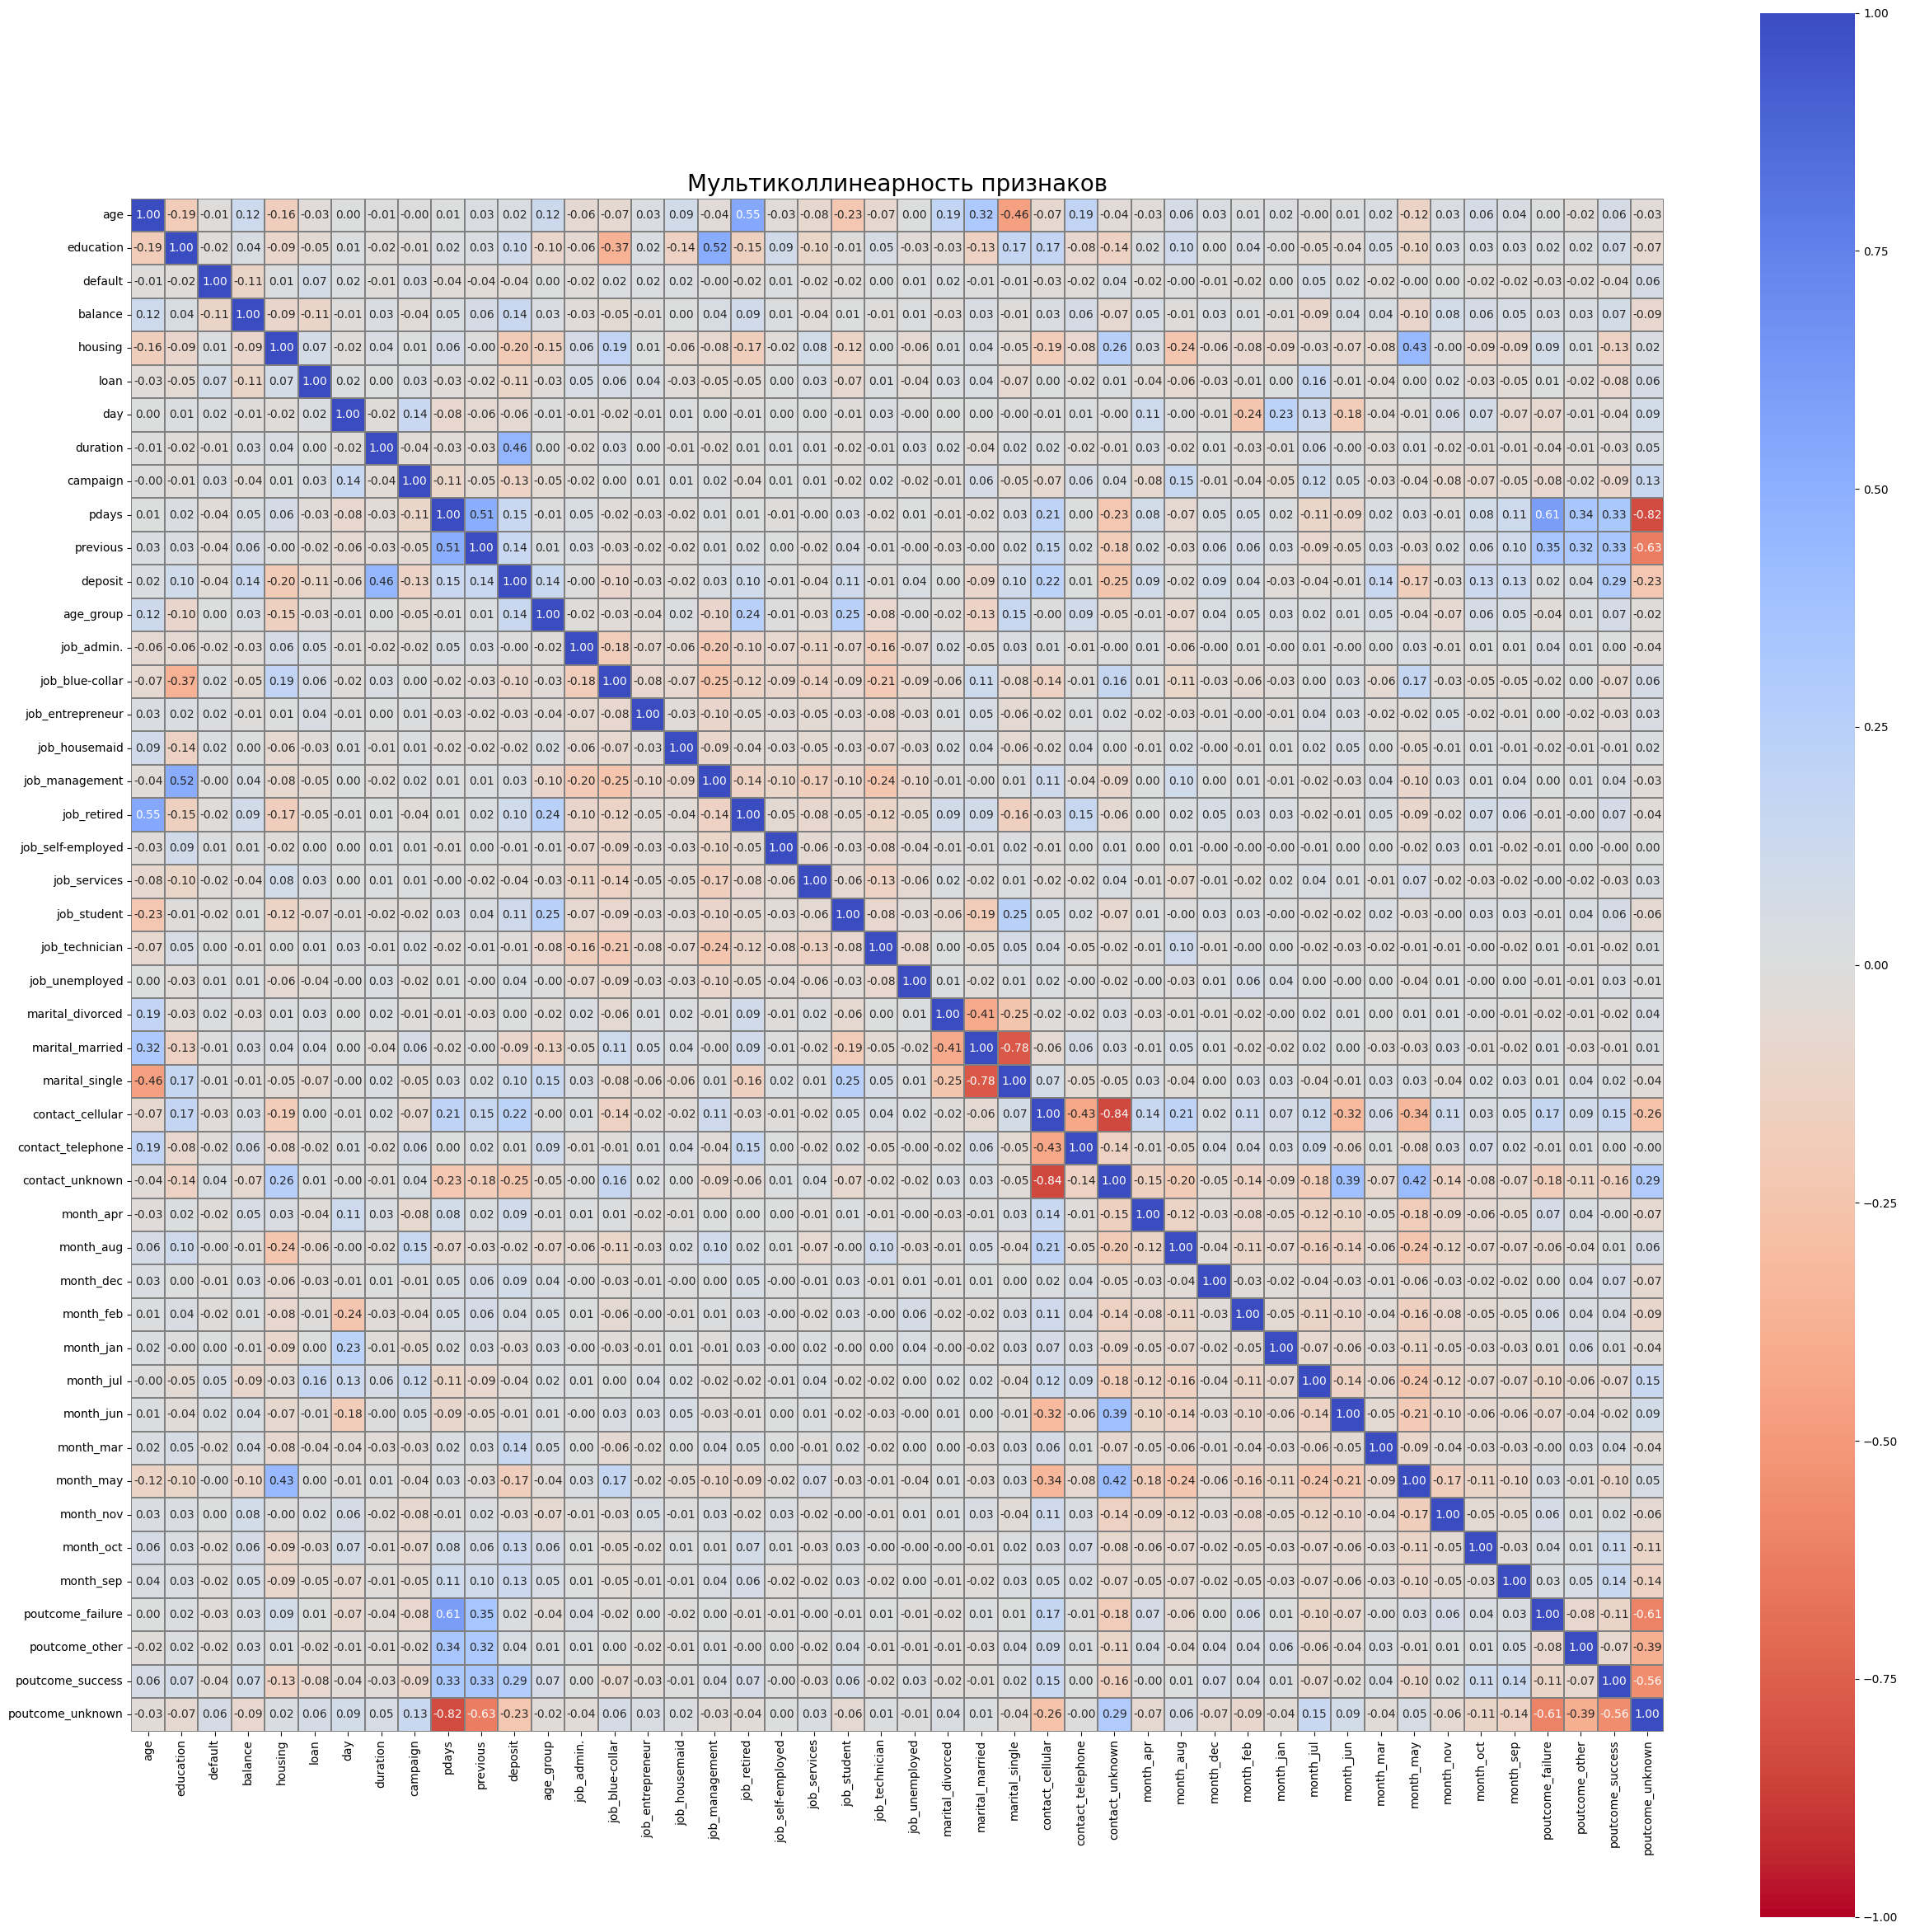

In [ ]:
# Вычисляем матрицу корреляции
df_corr = df.corr()

# Создаем фигуру для тепловой карты
plt.subplots(figsize=(30, 30))

# Создаем график - тепловая матрица с коэффициентами корреляции не менее 0.9
ax_heat_multicoll = sns.heatmap(
    # df_corr[df_corr.abs() >= 0.9],        # для вывода матрицы корреляции с коэффициентами не менее 0.9
    df_corr,
    vmin=-1,
    vmax=1,
    linewidth=0.05,
    linecolor='gray',
    cmap='coolwarm_r',
    annot = True,
    fmt='.2f',
    square=True
)
ax_heat_multicoll.set_title('Мультиколлинеарность признаков', fontsize=20);

plt.show()

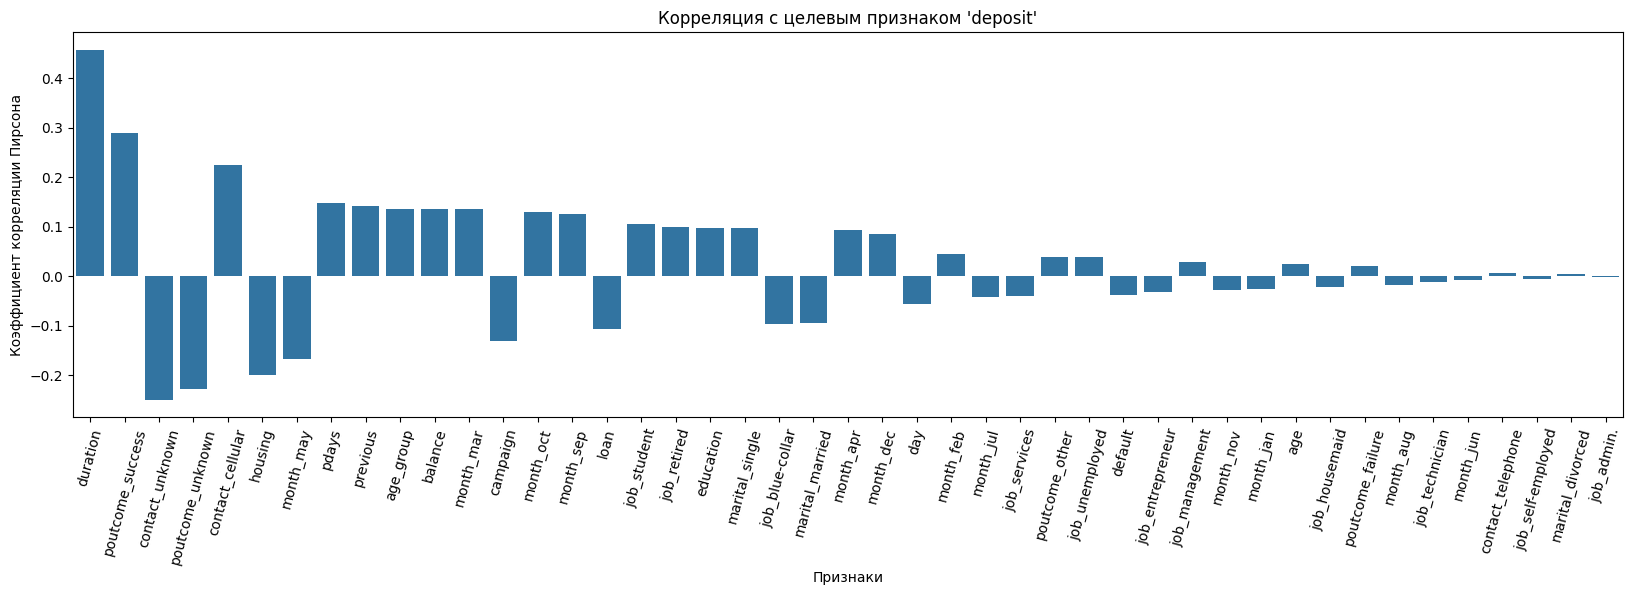

In [ ]:
# Создаем график ранжированных значений корреляции признаков с целевым признаком
fig = plt.figure(figsize=(20, 5))

# Датафрейм для графика
plot_df = df_corr.drop('deposit')      # убираем корреляцию 'deposit' с 'deposit' (самим собой)

# Ранжирование признаков, забираем только индексы
feature_order = abs(plot_df['deposit']).sort_values(ascending=False).index

# Создаем столбчатый график
ax_bar = sns.barplot(
    plot_df.reset_index(),
    x='index',
    y='deposit',
    order=feature_order
)
ax_bar.xaxis.set_tick_params(rotation=75)
ax_bar.set(title="Корреляция с целевым признаком 'deposit'",
    xlabel='Признаки',
    ylabel='Коэффициент корреляции Пирсона'
);

plt.show()

**Вывод:** <br>
Мультиколлинеарность признаков отсутсвует. <br>
Признаки наиболее коррелирующие с целевой переменной deposit:
* продолжительность контакта в секундах(duration)
* успех результата прошлой маркетинговой кампании(poutcome_success)
* контакт с клиентом по сотовому(contact_cellular)

### Задания 7 и 8

In [ ]:
# Сформируем матрицу признаков и целевого вектора
X = df.drop(['deposit'], axis=1)
y = df['deposit']

# Разделим данные на обучающую и тестовую выборки с учетом стратификации
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y, # обеспечение равномерного распределения классов
    random_state = 42, # фиксированное значение для генератора случайных чисел
    test_size = 0.33 # доля тестовой выборки
)

Рассчитайте необходимые показатели

In [ ]:
# Размерность тестовой выборки
print(f'Размерность тестовой выборки {X_test.shape}')

# Среднее значение целевой переменной на тестовой выборке
print(y_test.mean().__round__(2))

Размерность тестовой выборки (3335, 45)
0.46


### Задание 9

С помощью SelectKBest отберите 15 наиболее подходящих признаков

In [ ]:
# С помощью SelectKBest отбераем 15 наиболее подходящих признаков
selector = SelectKBest(score_func = f_classif, k=15)
selector.fit(X_train, y_train)
selector.get_feature_names_out()
selector_col = list(selector.get_feature_names_out())
selector_col

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

Нормализуйте данные с помощью minmaxsxaler

In [ ]:
# Задаём объект класса для скейлера
MMS_scaler = preprocessing.MinMaxScaler()

# Обучаем скейлер, подгоняем данные
MMS_scaler.fit(X_train)

# Транформируем данные обученным скейлером
X_train_scaled = MMS_scaler.transform(X_train)
X_test_scaled = MMS_scaler.transform(X_test)

In [ ]:
print(f'Среднее первого предиктора из тестовой выборки: {X_test_scaled[:, 0].mean().__round__(2)}')

Среднее первого предиктора из тестовой выборки: 0.31


## **Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья**

### Задание 1

Обучите логистическую регрессию и рассчитайте метрики качества


In [ ]:
log_model = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
log_model.fit(X_train_scaled, y_train)
y_test_pred = log_model.predict(X_test_scaled)
y_train_pred = log_model.predict(X_train_scaled)
print(f'Метрики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Метрики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Метрики на тестовых даннных
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      1790
           1       0.82      0.77      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.81      0.82      3335
weighted avg       0.82      0.82      0.82      3335

Метрики на тренировочных данных
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      3634
           1       0.85      0.80      0.82      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770



### Задания 2,3,4

Обучите решающие деревья, настройте максимальную глубину

In [ ]:
tree_model = tree.DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=6)
tree_model.fit(X_train_scaled, y_train)
y_test_pred = tree_model.predict(X_test_scaled)
y_train_pred = tree_model.predict(X_train_scaled)
print(f'Метрики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Метрики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Метрики на тестовых даннных
               precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.77      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335

Метрики на тренировочных данных
               precision    recall  f1-score   support

           0       0.87      0.79      0.83      3634
           1       0.78      0.86      0.82      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770



Визуализируем важные признаки в дереве решений

In [ ]:
# Создаем DataFrame для важности признаков
important_attributes = pd.DataFrame(
    [tree_model.feature_importances_],
    columns=X_train.columns  # используем названия столбцов из оригинального X_train
)

# Построим график для ТОП-10 важных признаков
fig = px.bar(
    x=list(important_attributes.loc[0].sort_values(ascending=False)[0:10].index),
    y=round(important_attributes.loc[0].sort_values(ascending=False)[0:10], 2),
    text_auto=True,
    title='ТОП-10 признаков'
)

fig.show()

In [ ]:
# Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(150, 100))

# Строим граф дерева решений
tree.plot_tree(
    tree_model,  # объект обученного дерева
    feature_names=X_train.columns,  # наименования факторов из оригинального DataFrame
    class_names=["0 - Not deposit", "1 - Yes deposit"],
    filled=True,
    fontsize=60
)

[Text(0.4486111111111111, 0.9285714285714286, 'duration <= 0.052\nentropy = 0.996\nsamples = 6770\nvalue = [3634, 3136]\nclass = 0 - Not deposit'),
 Text(0.20555555555555555, 0.7857142857142857, 'poutcome_success <= 0.5\nentropy = 0.7\nsamples = 2707\nvalue = [2194, 513]\nclass = 0 - Not deposit'),
 Text(0.32708333333333334, 0.8571428571428572, 'True  '),
 Text(0.11944444444444445, 0.6428571428571429, 'duration <= 0.022\nentropy = 0.608\nsamples = 2546\nvalue = [2166.0, 380.0]\nclass = 0 - Not deposit'),
 Text(0.05555555555555555, 0.5, 'month_mar <= 0.5\nentropy = 0.146\nsamples = 862\nvalue = [844, 18]\nclass = 0 - Not deposit'),
 Text(0.022222222222222223, 0.35714285714285715, 'balance <= 0.365\nentropy = 0.128\nsamples = 854\nvalue = [839.0, 15.0]\nclass = 0 - Not deposit'),
 Text(0.011111111111111112, 0.21428571428571427, 'entropy = 0.0\nsamples = 317\nvalue = [317, 0]\nclass = 0 - Not deposit'),
 Text(0.03333333333333333, 0.21428571428571427, 'month_feb <= 0.5\nentropy = 0.184\nsa

### Задание 5

Подберите оптимальные параметры с помощью gridsearch

In [ ]:
from sklearn.model_selection import GridSearchCV
# задаём сетку параметров
param_grid = [
              {'min_samples_split': [2, 5, 7, 10] , # Минимальное количество выборок, необходимое для разделения внутреннего узла
              'max_depth':[3,5,7] # Максимальная глубина дерева
               }
]

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy',

        random_state=42, # генератор случайных чисел
        ),
    param_grid=param_grid,
    n_jobs = -1,
    scoring='f1'
)

grid_search.fit(X_train_scaled, y_train)
print(f'Best Hyperparameter Values: {grid_search.best_params_}')
print(f'Best Models:{grid_search.best_estimator_}')
print(f'Best score Cross validation: {grid_search.best_score_:.3f}')
y_test_pred = grid_search.predict(X_test_scaled)
y_train_pred = grid_search.predict(X_train_scaled)
print(f'Метрики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Метрики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Best Hyperparameter Values: {'max_depth': 7, 'min_samples_split': 10}
Best Models:DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=10,
                       random_state=42)
Best score Cross validation: 0.800
Метрики на тестовых даннных
               precision    recall  f1-score   support

           0       0.80      0.85      0.82      1790
           1       0.81      0.75      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.80      0.80      0.80      3335
weighted avg       0.80      0.80      0.80      3335

Метрики на тренировочных данных
               precision    recall  f1-score   support

           0       0.82      0.88      0.85      3634
           1       0.85      0.77      0.81      3136

    accuracy                           0.83      6770
   macro avg       0.83      0.83      0.83      6770
weighted avg       0.83      0.83      0.83      6770



**Вывод:** <br>
* Best Hyperparameter Values: {'max_depth': 7, 'min_samples_split': 10}
* Best Models:DecisionTreeClassifier(criterion='entropy', max_depth=7, min_samples_split=10, random_state=42)<br>
Best score Cross validation: 0.800

## **Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза**

#### 1. Обучим на наших данных случайный лес

In [ ]:
# Параметры для RandomForestClassifier
params_rf_clf = {
    'n_estimators': 100, # число деревьев
    'criterion': 'gini',  # критерий эффективности
    'max_depth': 10, # максимальная глубина дерева
    'min_samples_leaf': 5, # число признаков из метода случайных подространств
    'random_state': 42 # генератор случайных чисел
}

# Создаем объект класса RandomForestClassifier
RFClf = RandomForestClassifier(**params_rf_clf)

# Обучение модели
RFClf.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_test_pred = RFClf.predict(X_test)

# Расчёт метрик
print("Метрики на тестовых данных:")
print(classification_report(y_test, y_test_pred))

Метрики на тестовых данных:
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1790
           1       0.81      0.85      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335



#### 2. Используем для классификации градиентный бустинг и сравним качество со случайным лесом

In [ ]:
# Параметры GradientBoostingClassifier
params_gb_clf = {
    'max_depth': 5, # максимальная глубина дерева
    'learning_rate': 0.05, # темп обучения
    'min_samples_leaf': 5, # число признаков из метода случайных подространств
    'n_estimators': 300, # число деревьев
    'random_state': 42 # генератор случайных чисел
}

# Создаем объект GradientBoostingClassifier
GBClf = GradientBoostingClassifier(**params_gb_clf)

# Обучение модели
GBClf.fit(X_train, y_train)

# Предсказания на тестовой выборке
y_test_pred = GBClf.predict(X_test)

print("Метрики на тестовых данных:")
print(classification_report(y_test, y_test_pred))

Метрики на тестовых данных:
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1790
           1       0.82      0.87      0.85      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.86      0.85      0.85      3335



#### 3. Объединим уже известные нам алгоритмы с помощью стекинга

In [ ]:
# Определяем базовые модели
DTClf = DecisionTreeClassifier(max_depth=5, random_state=42)
LR = LogisticRegression(random_state=42)
GBClf = GradientBoostingClassifier(max_depth=5, n_estimators=100, random_state=42)

# Создаем список кортежей базовых моделей
stkng_estimators_ = [
    ('dt_clf', DTClf),
    ('log_reg', LR),
    ('gboost', GBClf)
]

# Создаем объект класса StackingClassifier
StkngClf = StackingClassifier(
    estimators=stkng_estimators_,
    final_estimator=LogisticRegression(random_state=42),  # логистическая регрессия как метамодель
    passthrough=False,  # передаём только прогнозы базовых моделей
    cv=5                # используем 5-кратную кросс-валидацию
)

# Обучаем модель стекинга
%time StkngClf.fit(X_train_scaled, y_train)

# Предсказания и метрики
y_test_pred = StkngClf.predict(X_test_scaled)

print("Метрики на тестовых данных:")
print(classification_report(y_test, y_test_pred))

CPU times: user 14.7 s, sys: 406 ms, total: 15.1 s
Wall time: 15 s
Метрики на тестовых данных:
              precision    recall  f1-score   support

           0       0.87      0.84      0.86      1790
           1       0.83      0.85      0.84      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335



#### 4. Оценим, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

In [ ]:
# Создаем DataFrame для важности признаков
imp= pd.DataFrame(
    {'feature': X_train.columns, 'importance': gb.feature_importances_}
)

# Сортируем по важности в порядке убывания и отбираем топ-10
imp_sorted = imp.sort_values(by='importance', ascending=False).head(10)

# Строим график
fig = px.bar(
   imp_sorted,
    x='feature',
    y='importance',
    text_auto=True,
    title='ТОП-10 признаков градиентного бустинга'
)

fig.show()


#### 5. Реализуем оптимизацию гиперпараметров с помощью Optuna

In [ ]:
!pip install optuna
import optuna
from sklearn import ensemble, metrics

def optuna_rf(trial):
    # Задаем пространство поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 10)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # Создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=42)

    # Обучаем модель
    model.fit(X_train_scaled, y_train)

    # Оценка модели на тестовых данных
    y_pred = model.predict(X_test_scaled)
    score = metrics.f1_score(y_test, y_pred)

    return score

# Создаем и запускаем изучение гиперпараметров
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
study.optimize(optuna_rf, n_trials=20)

# Получаем лучшие гиперпараметры и обучаем финальную модель
print(f"Best Hyperparameters: {study.best_params}")

# Используем лучшие параметры для финальной модели
best_model = ensemble.RandomForestClassifier(**study.best_params, random_state=42)
best_model.fit(X_train_scaled, y_train)

# Оценка модели на тестовых данных
y_test_pred = best_model.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

[I 2025-01-17 03:46:06,645] A new study created in memory with name: RandomForestClassifier
[I 2025-01-17 03:46:09,108] Trial 0 finished with value: 0.8472568578553616 and parameters: {'n_estimators': 180, 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8472568578553616.
[I 2025-01-17 03:46:11,253] Trial 1 finished with value: 0.8419083255378859 and parameters: {'n_estimators': 170, 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.8472568578553616.
[I 2025-01-17 03:46:12,708] Trial 2 finished with value: 0.8363522798251093 and parameters: {'n_estimators': 170, 'max_depth': 11, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8472568578553616.
[I 2025-01-17 03:46:14,417] Trial 3 finished with value: 0.8398376522010615 and parameters: {'n_estimators': 200, 'max_depth': 18, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8472568578553616.
[I 2025-01-17 03:46:15,641] Trial 4 finished with value: 0.8446389496717724 and parameters: {'n_

Best Hyperparameters: {'n_estimators': 180, 'max_depth': 24, 'min_samples_leaf': 3}
              precision    recall  f1-score   support

           0       0.89      0.83      0.86      1790
           1       0.82      0.88      0.85      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.86      0.85      3335
weighted avg       0.86      0.85      0.85      3335

f1_score на тестовом наборе: 0.83


**Вывод:**<br>
В ходе исследования выделено 3 наиболее важных признака:
* duration (продолжительность контакта в секундах) - оптимальная продолжительность контакта находится в диапазоне - до 5 минут;
* poutcome_success (результат прошлой маркетинговой кампании) - success (успех, согласие);
* contact_unknown (тип контакта с клиентом) - unknown (неизвестный).
Данные факторы показывают, что превалирующее значение в решении открыть клиентом депозит (со стороны клиента) играют внешние факторы, т.е. то, что зависит от сотрудников банка, занятых в данной маркетинговой кампании - их навыков коммуникаций, проведение холодных звонков, умение подробно, доступно и просто излагать информацию клиентам и т.д.

Вторичные внутренние факторы для конкретного клиента:
* job_student, job_retired (сфера занятости) - целевая аудитория это студенты и клиенты находящиеся на пенсии;
* age_group (возрастная группа) - потенциальные группы - младше 31 и старше 60;
* marital (семейное положение) - клиенты не состоящие в браке;
* month (месяц контакта с клиентом) - наиболее благоприятный месяц для открытия депозита, когда стоит увеличить активность контактов с клиентами - это декабрь, наименее результативный - май.

И другие факторы, которые тоже влияют на решение клиента, в меньшей степени, что необходимо учитывать при планировании будущей маркетинговой кампании.
Также стоит упомянуть о лояльности клиентов - как показали исследования, клиенты, ранее открывшие депозиты в прошлые маркетиновые кампании, охотно соглашаются и в новой кампании - данную группу необходимо использовать в новых маркетинговых кампаниях и сохранять их лояльность.

Для решения задачи классификации в данном кейсе хорошо себя показали модели:
- поиск по сетке,
- градиентного бустинга,
- случайного леса с подобранными гиперпараметрами методом Optuna,
- модель случайного леса со стартовыми параметрами также показала себя, весьма, неплохо.

Итого в результате выполненных расчетов:
1. Метод LogisticRegression: F1-score =	0.80
2. Метод DecisionTreeClassifier: F1-score =	0.80
3. Метод GridSearchCV: F1-score = 0.78
4. Метод RandomForestClassifier: F1-score = 0.83
5. Метод GradientBoostingClassifier: F1-score = 0.85
6. Метод StackingClassifier: F1-score = 0.84
7. Метод RandomForestClassifier + Optuna: F1-score = 0.83